# Описание проекта

Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.

У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.


Вы изучите:

- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

# Описание данных

Таблица `visits` (лог сервера с информацией о посещениях сайта):

- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь


Таблица `orders` (информация о заказах):

- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа


Таблица `costs` о затратах на маркетинг):

- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

## Шаг 1. Загрузите данные и подготовьте их к анализу

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import factorial
from scipy import stats as st
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
display(visits.sample(5))
display(orders.sample(5))
display(costs.sample(5))

,Device,End Ts,Source Id,Start Ts,Uid
279592,touch,2017-08-13 16:41:00,4,2017-08-13 16:40:00,6108727097912943654
59716,desktop,2017-12-11 13:48:00,3,2017-12-11 13:47:00,1309964012116063511
248692,touch,2017-11-07 12:04:00,3,2017-11-07 11:56:00,12718510723160006476
58480,desktop,2018-04-25 10:28:00,9,2018-04-25 10:28:00,7478054213403174082
288619,desktop,2018-03-22 18:35:00,5,2018-03-22 18:32:00,11406403846328051819


,Buy Ts,Revenue,Uid
45629,2018-04-26 16:30:00,1.92,14736427291782143324
9463,2017-09-28 14:06:00,34.22,9737640335185488211
23833,2017-12-13 15:03:00,1.83,1346110319806407685
35478,2018-02-18 09:10:00,2.44,18082221523025596971
39959,2018-03-15 13:15:00,0.85,1957391967428828072


,source_id,dt,costs
2303,10,2017-10-03,38.51
622,2,2018-02-15,181.31
1623,5,2017-11-19,191.84
244,1,2018-01-31,97.70
440,2,2017-08-17,97.53


Вывод: Необходимо привести названия столбцов к нижнему регистру и убрать пробелы (не по айтишному это :) )

In [4]:
display(visits.info())
display(orders.info())
display(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

Вывод: Необходимо привести `End Ts`, `Start Ts`, `Buy Ts`, `dt` к типу данных `datetime`

In [5]:
display(visits.describe())
display(orders.describe())
display(costs.describe())

,Source Id,Uid
count,"359,400.00","359,400.00"
mean,3.75,"9,202,556,994,354,921,472.00"
std,1.92,"5,298,432,824,659,611,648.00"
min,1.00,"11,863,502,262,781.00"
25%,3.00,"4,613,406,732,167,550,976.00"
50%,4.00,"9,227,412,908,740,601,856.00"
75%,5.00,"13,728,237,011,236,173,824.00"
max,10.00,"18,446,676,030,785,673,216.00"


,Revenue,Uid
count,"50,415.00","50,415.00"
mean,5.00,"9,098,160,634,289,729,536.00"
std,21.82,"5,285,741,550,834,715,648.00"
min,0.00,"313,578,113,262,317.00"
25%,1.22,"4,533,566,627,250,599,936.00"
50%,2.50,"9,102,273,602,618,561,536.00"
75%,4.89,"13,682,901,980,465,401,856.00"
max,"2,633.28","18,446,167,067,214,817,280.00"


,source_id,costs
count,"2,542.00","2,542.00"
mean,4.86,129.48
std,3.18,156.30
min,1.00,0.54
25%,2.00,21.95
50%,4.00,77.30
75%,9.00,170.06
max,10.00,"1,788.28"


In [6]:
display(visits.duplicated().sum())
display(orders.duplicated().sum())
display(costs.duplicated().sum())

0

0

0

Вывод: Дубликатов нет.

In [7]:
#построим детально на колонку device
visits['Device'].unique()

array(['touch', 'desktop'], dtype=object)

Вывод: Все впорядке

In [8]:
#приведем названия столбцов к нижнему регистру и уберем пробелы
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()

In [9]:
#проверим
print(visits.columns)
print(orders.columns)

Index(['device', 'end ts', 'source id', 'start ts', 'uid'], dtype='object')
Index(['buy ts', 'revenue', 'uid'], dtype='object')


In [10]:
columns_visits = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
columns_orders = ['buy_ts', 'revenue', 'uid']

visits.set_axis(columns_visits, axis='columns', inplace=True)
orders.set_axis(columns_orders, axis='columns', inplace=True)

In [11]:
#проверим
print(visits.columns)
print(orders.columns)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')
Index(['buy_ts', 'revenue', 'uid'], dtype='object')


In [12]:
#изменим тип данных на datetime 
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [13]:
#проверим
display(visits.info())
display(orders.info())
display(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


None

Вывод:

- ознакомились с данными
- привели названия столбцов к нижнему регистру и убрали пробелы
- привели столбцы с датами в нужный нам тип datetime 
- проверили датасеты на дубликаты (их нет)
- проверили датасеты на пропуски (их нет)

Использовали методы:
    
- info()
- describe()
- str.lower()
- display()
- to_datetime()
- unique()
- duplicated()
- sum()
- sample()

## Шаг 2. Постройте отчёты и посчитайте метрики

### Продукт

### Изучим таблицу visits

- **Сколько людей пользуются в день, неделю, месяц?**

In [14]:
visits.head(1)

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062


In [15]:
#вынесем в отдельные столбцы дату, неделю, месяц
visits['session_date'] = visits['start_ts'].dt.date
visits['session_week'] = visits['start_ts'].dt.week
visits['session_month'] = visits['start_ts'].dt.month
visits['session_year'] = visits['start_ts'].dt.year

#посчитаем длительность сессии
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

#посчитаем dau, wau, mau
dau = visits.groupby(['session_date']).agg({'uid':'nunique'}).mean()
wau = visits.groupby(['session_week']).agg({'uid':'nunique'}).mean()
mau = visits.groupby(['session_month']).agg({'uid':'nunique'}).mean()

#выведем получившиеся значения
print('Количество пользователей в день: {}'.format(int(dau)))
print('Количество пользователей в неделю: {}'.format(int(wau)))
print('Количество пользователей в месяц: {}'.format(int(mau)))

Количество пользователей в день: 907
Количество пользователей в неделю: 5825
Количество пользователей в месяц: 23228


In [16]:
#рассчитаем Sticky Factor - показатель лояльности/вовлечённости аудитории к приложению
sticky_wau = dau / wau
sticky_mau = dau / mau

print('Процесс вовлеченности аудитории за неделю: {:.2%}'.format(sticky_wau[0]))
print('Процесс вовлеченности аудитории за месяц: {:.2%}'.format(sticky_mau[0]))

Процесс вовлеченности аудитории за неделю: 15.59%
Процесс вовлеченности аудитории за месяц: 3.91%


**Посмотрим на динамику посещаемости на графиках:**

In [17]:
dau_dynamic = visits.groupby(['session_date']).agg({'uid':'nunique'})
wau_dynamic = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
mau_dynamic = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'})

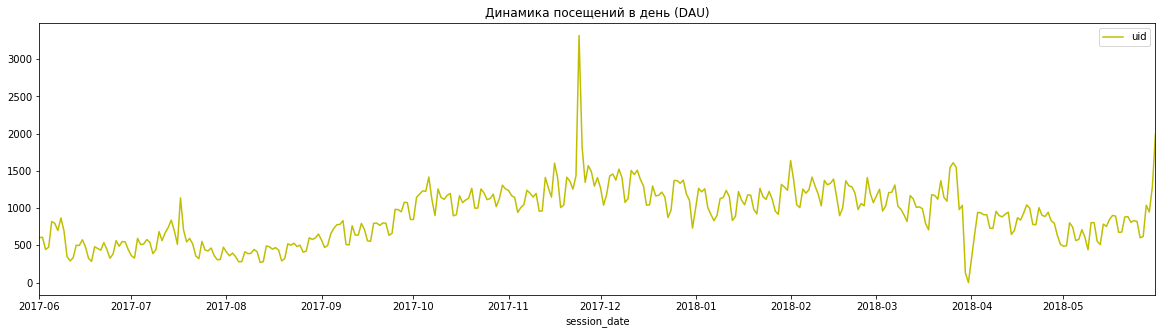

In [18]:
dau_dynamic.plot(figsize=(20, 5), color='y', title='Динамика посещений в день (DAU)')

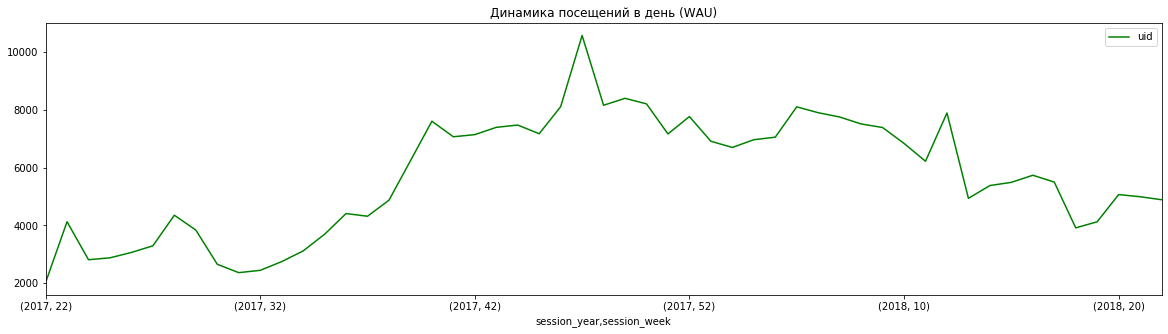

In [19]:
wau_dynamic.plot(figsize=(20, 5),  color='g', title='Динамика посещений в день (WAU)')

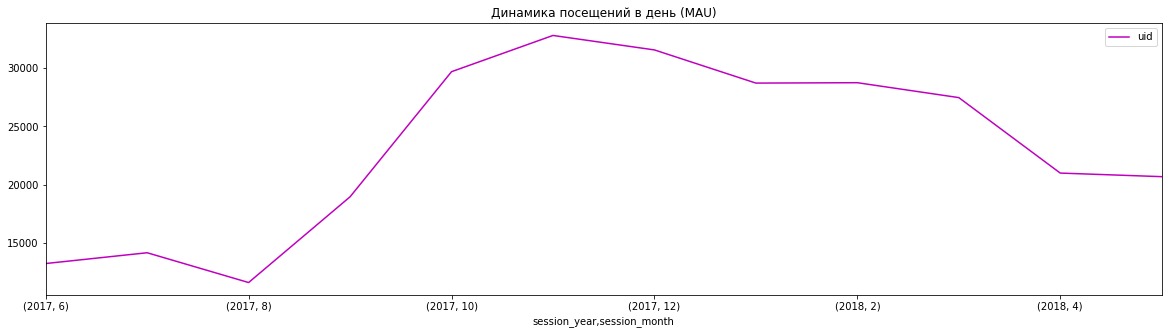

In [20]:
mau_dynamic.plot(figsize=(20, 5), color='m', title='Динамика посещений в день (MAU)')

Вывод:

- наблюдается сезонность в посещении Яндекс.Афиши
- начиная с сентября повышается спрос на пользование сервисов, можно выделить период осень-зима
- в летний период Яндекс.Афиша не пользуется популярностью, возможно связано с тем, что люди уезжают на отдных и берут отпуска, но проверить не было ли в тот период технических неполадок не будет лишним

**Проанализируем есть ли зависимость от того какими устройствами пользуются пользователи:**

In [21]:
visits.sample(2)

,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_year,session_duration
116257,desktop,2018-01-02 21:39:00,5,2018-01-02 21:30:00,7060988368045504790,2018-01-02,1,1,2018,540
260795,desktop,2017-12-04 11:35:00,5,2017-12-04 11:04:00,6474709813165193002,2017-12-04,49,12,2017,1860


In [22]:
#сделаем срезы по типам устройств
visits_d = visits.query('device == "desktop"')
visits_t = visits.query('device == "touch"')

#найдем dau, wau, mau
d_dau = visits_d.groupby(['session_date']).agg({'uid':'nunique'}).mean()
d_wau = visits_d.groupby(['session_week']).agg({'uid':'nunique'}).mean()
d_mau = visits_d.groupby(['session_month']).agg({'uid':'nunique'}).mean()

t_dau = visits_t.groupby(['session_date']).agg({'uid':'nunique'}).mean()
t_wau = visits_t.groupby(['session_week']).agg({'uid':'nunique'}).mean()
t_mau = visits_t.groupby(['session_month']).agg({'uid':'nunique'}).mean()

#выведем полученные результ аты
print('Пользователи компьютеров:')
print('Количество пользователей в день: {}'.format(int(d_dau)))
print('Количество пользователей в неделю: {}'.format(int(d_wau)))
print('Количество пользователей в месяц: {}'.format(int(d_mau)))
print()
print('Пользователи мобильных устройств:')
print('Количество пользователей в день: {}'.format(int(t_dau)))
print('Количество пользователей в неделю: {}'.format(int(t_wau)))
print('Количество пользователей в месяц: {}'.format(int(t_mau)))

Пользователи компьютеров:
Количество пользователей в день: 659
Количество пользователей в неделю: 4208
Количество пользователей в месяц: 16724

Пользователи мобильных устройств:
Количество пользователей в день: 252
Количество пользователей в неделю: 1666
Количество пользователей в месяц: 6825


In [23]:
#рассчитаем Sticky Factor - показатель лояльности/вовлечённости аудитории к приложению для разных типов устройств
sticky_d_wau = d_dau / d_wau
sticky_d_mau = d_dau / d_mau

sticky_t_wau = t_dau / t_wau
sticky_t_mau = t_dau / t_mau

print('Пользователи компьютеров:')
print('Процесс вовлеченности аудитории за неделю: {:.2%}'.format(sticky_d_wau[0]))
print('Процесс вовлеченности аудитории за месяц: {:.2%}'.format(sticky_d_mau[0]))
print()
print('Пользователи мобильных устройств:')
print('Процесс вовлеченности аудитории за неделю: {:.2%}'.format(sticky_t_wau[0]))
print('Процесс вовлеченности аудитории за месяц: {:.2%}'.format(sticky_t_mau[0]))

Пользователи компьютеров:
Процесс вовлеченности аудитории за неделю: 15.67%
Процесс вовлеченности аудитории за месяц: 3.94%

Пользователи мобильных устройств:
Процесс вовлеченности аудитории за неделю: 15.18%
Процесс вовлеченности аудитории за месяц: 3.70%


**Построим на динаму посещаемости в зависимости от типа устройств на графиках:**

In [24]:
#dau_d_dynamic = visits_d.groupby(['session_date']).agg({'uid':'nunique'})
#wau_d_dynamic = visits_d.groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
#mau_d_dynamic = visits_d.groupby(['session_year', 'session_month']).agg({'uid':'nunique'})

#dau_t_dynamic = visits_t.groupby(['session_date']).agg({'uid':'nunique'})
#wau_t_dynamic = visits_t.groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
#mau_t_dynamic = visits_t.groupby(['session_year', 'session_month']).agg({'uid':'nunique'})


dau_dynamic_pivot = visits.pivot_table(index='session_date', columns='device', values='uid', aggfunc='nunique')
wau_dynamic_pivot = visits.pivot_table(index=['session_year', 'session_week'], columns='device', values='uid', aggfunc='nunique')
mau_dynamic_pivot = visits.pivot_table(index=['session_year', 'session_month'], columns='device', values='uid', aggfunc='nunique')

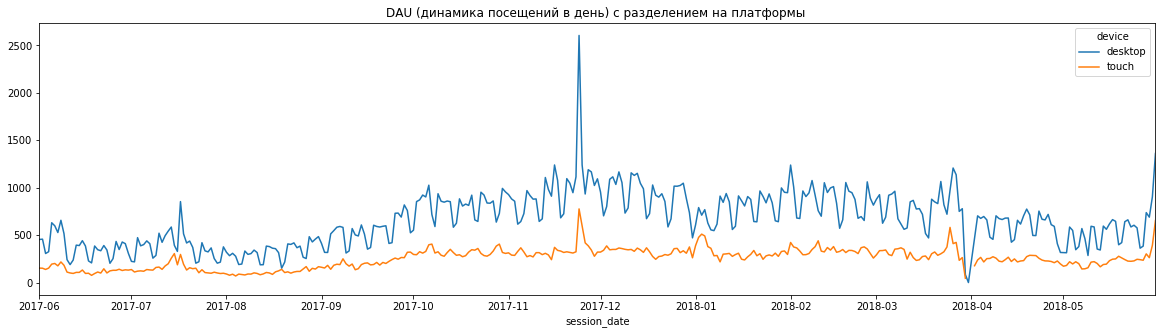

In [25]:
#построим на графике динамику продаж с разделением по платформам
dau_dynamic_pivot.plot(figsize = (20, 5), title='DAU (динамика посещений в день) с разделением на платформы ')

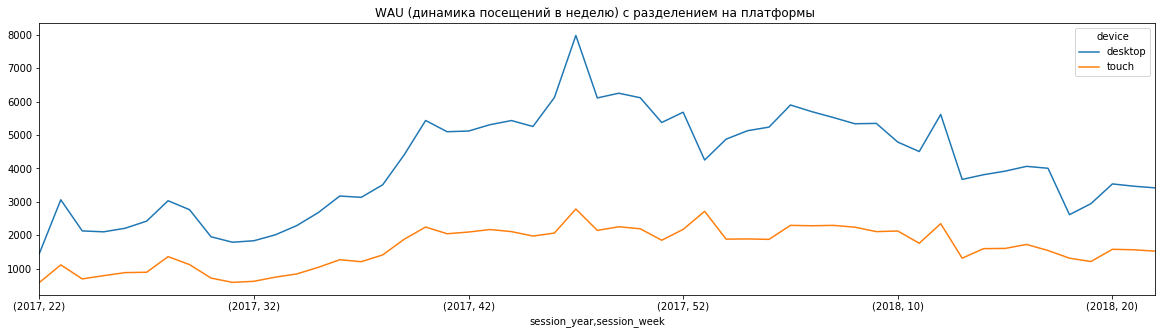

In [26]:
#построим на графике динамику продаж с разделением по платформам
wau_dynamic_pivot.plot(figsize = (20, 5), title='WAU (динамика посещений в неделю) с разделением на платформы ')

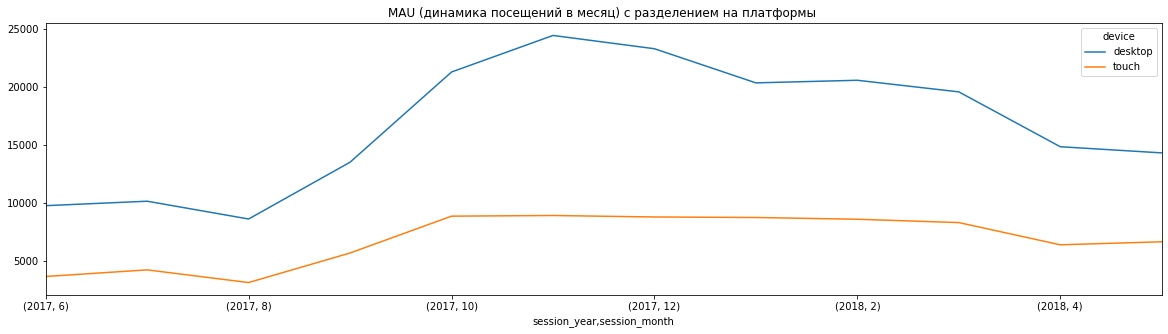

In [27]:
#построим на графике динамику продаж с разделением по платформам
mau_dynamic_pivot.plot(figsize = (20, 5), title='MAU (динамика посещений в месяц) с разделением на платформы ')

Вывод: Динамика посещений с стационарных устройств выглядит намного лучше.

### **Вывод:**

- выделили день, неделю, месяц, год в отдельный столбец
- выделили столбец с длительностью сессийё
- выделили `dau`, `mau`, `wau` для всего датафрейма
- выделили `dau`, `mau`, `wau` в разрезе типа используемого устройства
- нашли `Sticky Factor` для всего дата врейма
- нашли `Sticky Factor` в разрезе типа используемого устройства
- посчитали динамику посещения Яндекс.Афиши и построили графики для всего дата фрейма
- посчитали динамику посещения Яндекс.Афиши в разрезе используемого устройства

**По всем типам устройств:**

- Количество пользователей в день: 907
- Количество пользователей в неделю: 5825
- Количество пользователей в месяц: 23228

- Процесс вовлеченности аудитории за неделю: 15.59%
- Процесс вовлеченности аудитории за месяц: 3.91%

**В разрезе разных устройств:**

_Пользователи компьютеров:_

- Количество пользователей в день: 659
- Количество пользователей в неделю: 4208
- Количество пользователей в месяц: 16724

_Пользователи мобильных устройств:_

- Количество пользователей в день: 252
- Количество пользователей в неделю: 1666
- Количество пользователей в месяц: 6825

_Пользователи компьютеров:_

- Процесс вовлеченности аудитории за неделю: 15.67%
- Процесс вовлеченности аудитории за месяц: 3.94%

_Пользователи мобильных устройств:_

- Процесс вовлеченности аудитории за неделю: 15.18%
- Процесс вовлеченности аудитории за месяц: 3.70%

**В целом могу выделить следующее:**

1. Есть сезонность и люди используют Яндекс.Афишу больше всего в период осени-зимы
2. Пользователей с компьютеров больше в 3 раза чем пользователесь с мобильных устройств
3. В декабре есть период аномальной активности, нужно сообщить отделу маркетинга, что бы они его проверили

- **Сколько сессий в день?**

In [28]:
visits_day = visits.groupby(['session_date']).agg({'uid':'count'})
print('Сессий в день в среднем: {}'.format(int(visits_day.mean()[0])))

Сессий в день в среднем: 987


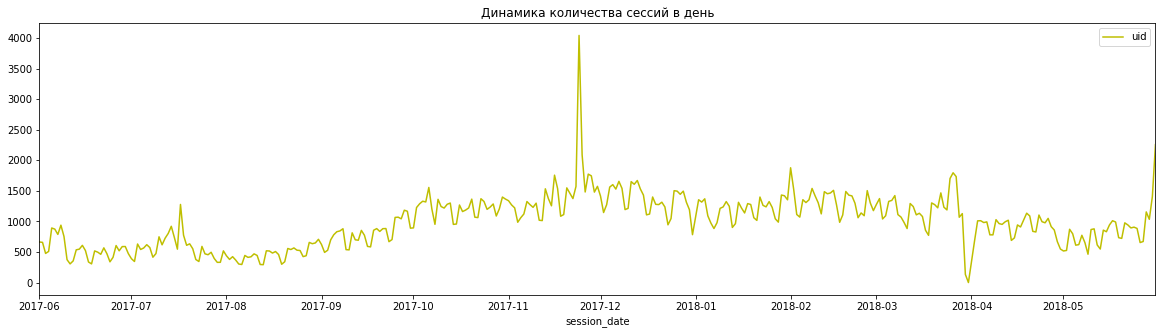

In [29]:
visits_day.plot(figsize=(20,5), color='y', title = 'Динамика количества сессий в день')

Вывод: Видно, что аномалии в декабре, так же отразились и на количестве

- **Сколько длится одна сессия?**

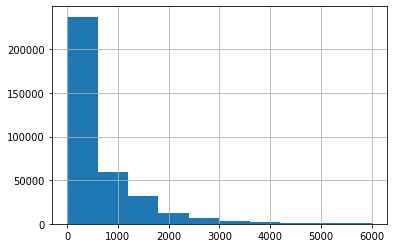

In [30]:
visits['session_duration'].hist(bins=10, range=(0, 6000))
plt.show()

Распределение не нормальное, среднее и медиану нет смысла смотреть, посмотрим на моду

In [31]:
duration_mode = visits['session_duration'].mode()
print('Мода одной сессии: {}'.format(int(duration_mode)))

Мода одной сессии: 60


Вывод: Мода одной сессии составляет 60 секунд, считаю это не большим показателям, необходимо об этом сообщить маркетингу.

In [32]:
duration_d_mode = visits_d['session_duration'].mode()
print('Мода одной сессии: {}'.format(int(duration_d_mode)))

Мода одной сессии: 60


In [33]:
duration_t_mode = visits_t['session_duration'].mode()
print('Мода одной сессии: {}'.format(int(duration_t_mode)))

Мода одной сессии: 60


**Вывод: Нет отличий в длительности сессий использования на разных устройствах, мода составляет 60 секунд.**

- **Как часто люди возвращаются?**

In [34]:
#выделим дату первого визита в переменную
first_visit = visits.groupby('uid')['start_ts'].min().reset_index()

#названия столбцов
first_visit.columns = ['uid', 'first_visit']

first_visit.head()

,uid,first_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [35]:
#смержим с visits
visits = visits.merge(first_visit, on='uid')

In [36]:
#проверяем
visits.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_year,session_duration,first_visit
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,10,3,2018,1680,2018-03-09 20:05:00


In [37]:
#сделаем столбцы с первым месяцем визита и просто месяцем визита
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')

In [38]:
#создадим столбец с продолжительностью использования
visits['lifetime'] = (visits['visit_month'] - visits['first_visit_month']) / np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

In [39]:
#сделаем когорты
cohort_visits = visits.groupby(['first_visit_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()
f_uid = cohort_visits[cohort_visits['lifetime'] == 0][['first_visit_month', 'uid']]
f_uid.columns = ['first_visit_month', 'f_uid']

display(f_uid)

,first_visit_month,f_uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [40]:
cohort_visits = cohort_visits.merge(f_uid)
cohort_visits['retention'] = cohort_visits['uid'] / cohort_visits['f_uid']
retention_pivot = cohort_visits.pivot_table(index = 'first_visit_month', 
                                                   columns = 'lifetime', values = 'retention', aggfunc = 'sum')

retention_pivot.mean() * 100

lifetime
0    100.00
1      6.52
2      4.63
3      4.28
4      4.06
5      3.94
6      3.70
7      3.75
8      3.55
9      3.52
10     3.41
11     4.50
dtype: float64

In [41]:
del retention_pivot[0]

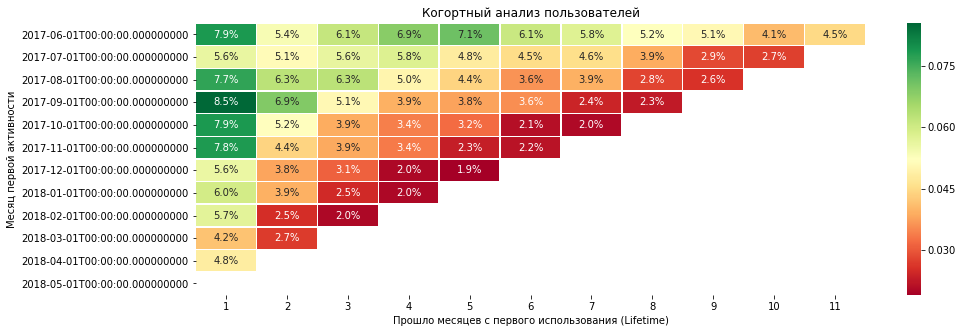

In [42]:
plt.figure(figsize=(15, 5))
plt.title('Когортный анализ пользователей')
sns.heatmap(retention_pivot, vmin=None, vmax=None, annot=True, fmt=".1%", linewidths=.5, cmap = 'RdYlGn')
plt.ylabel('Месяц первой активности')
plt.xlabel('Прошло месяцев с первого использования (Lifetime)')
plt.show()

#### Вывод:

- После первого месяца использования очень мало людей продолжают использовать на ежемесячной основе.
- Возвращается очень маленький процент людей и с течением времени он падает.

### Продажи

- **Когда люди начинают покупать?**

In [43]:
#найдём время и дату первых сессий 
first_sessions = visits.groupby(['uid']).agg({'start_ts':'min', 'source_id':'first'})
first_sessions.columns = ['first_activity', 'first_source']

#найдем время первой покупки
first_orders = orders.groupby(['uid']).agg({'buy_ts':'min'})
first_orders.columns = ['first_buy_ts']

#добавим дату и время первой сессии в информацию по первым заказам
first_orders = first_orders.join(first_sessions,on='uid')

Медиана времени первой покупки: 16 минут
Среднее времени первой покупки: 16 дней
Мода времени первой покупки: 1 минута


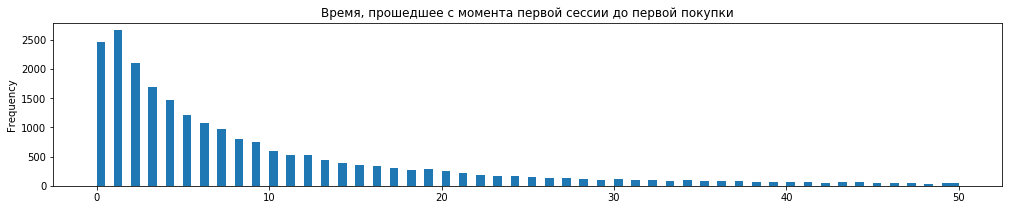

In [44]:
#найдем время, прошедшее с момента первой сессии до первой покупки
first_orders['time_to_first_purchase'] = (first_orders['first_buy_ts'] - first_orders['first_activity']) / np.timedelta64(1, 'm')
first_orders['time_to_first_purchase'].plot(kind = 'hist', bins = 100, range = (0,50), figsize = (17,3), 
                                            title = 'Время, прошедшее с момента первой сессии до первой покупки')

print('Медиана времени первой покупки: {} минут'.format(int(first_orders['time_to_first_purchase'].median())))
print('Среднее времени первой покупки: {} дней'.format(int(first_orders['time_to_first_purchase'].mean()/60/24)))
print('Мода времени первой покупки: {} минута'.format(int(first_orders['time_to_first_purchase'].mode())))

Вывод: покупки как правило происходят во время первой сессии.

- **Сколько раз покупают за период?**

In [45]:
#добавим в orders дату первого заказа и выведем в отдельный столбец месяц первого заказа
orders = orders.join(first_orders, on='uid')

In [46]:
orders['first_buy_month'] = orders['first_buy_ts'].astype('datetime64[M]')
orders['first_session_month'] = orders['first_activity'].astype('datetime64[M]')
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

In [47]:
orders['buy_date'] = orders['buy_ts'].dt.date
orders['buy_week'] = orders['buy_ts'].dt.week
orders['buy_year'] = orders['buy_ts'].dt.year

day_purchases_per_user = orders.groupby(['buy_date', 'uid']).agg({'buy_ts':'count'}).mean()[0]
week_purchases_per_user = orders.groupby(['buy_year', 'buy_week', 'uid']).agg({'buy_ts':'count'}).mean()[0]
month_purchases_per_user = orders.groupby(['buy_month', 'uid']).agg({'buy_ts':'count'}).mean()[0]
year_purchases_per_user = orders.groupby(['buy_year', 'uid']).agg({'buy_ts':'count'}).mean()[0]

print('''В среднем на одного пользователя покупок:
В день - {:.2f},
В неделю - {:.2f},
В месяц - {:.2f},
В год - {:.2f}

'''.format(day_purchases_per_user, week_purchases_per_user, month_purchases_per_user, year_purchases_per_user))

В среднем на одного пользователя покупок:
В день - 1.08,
В неделю - 1.16,
В месяц - 1.23,
В год - 1.32




In [48]:
purchase_by_month = (orders.merge(visits, on='uid', how='inner'))\
                    .groupby(['buy_month', 'device'])\
                    .agg({'buy_ts':'count'})

purchase_by_month.reset_index()

,buy_month,device,buy_ts
0,2017-06-01,desktop,24330
1,2017-06-01,touch,1509
2,2017-07-01,desktop,32432
3,2017-07-01,touch,1937
4,2017-08-01,desktop,34575
5,2017-08-01,touch,1271
6,2017-09-01,desktop,62715
7,2017-09-01,touch,2441
8,2017-10-01,desktop,67711
9,2017-10-01,touch,5912


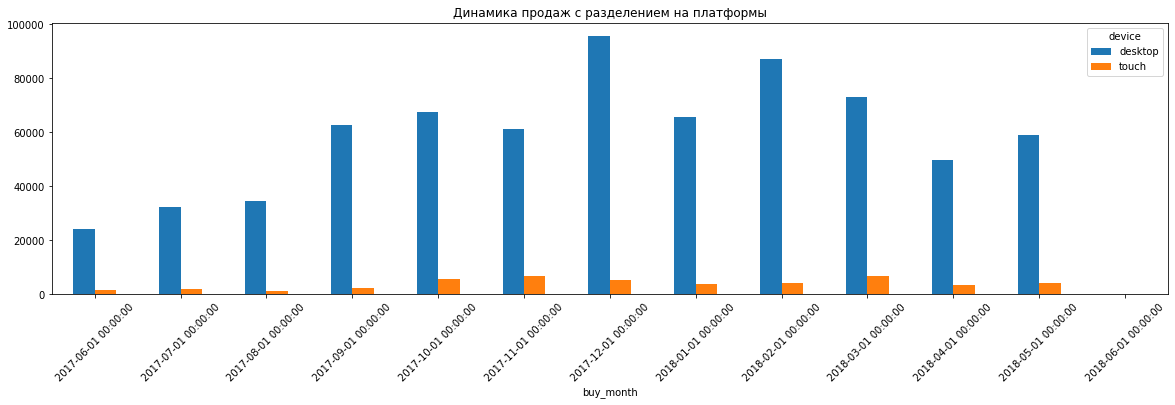

In [49]:
#построим сводную таблицу по месяцам покупок
purchase_by_month_pivot=\
                purchase_by_month.pivot_table(index='buy_month', columns='device', values='buy_ts', aggfunc='mean')

#постриом график
purchase_by_month_pivot\
                .plot(kind='bar', figsize = (20,5), title = 'Динамика продаж с разделением на платформы', rot=45)

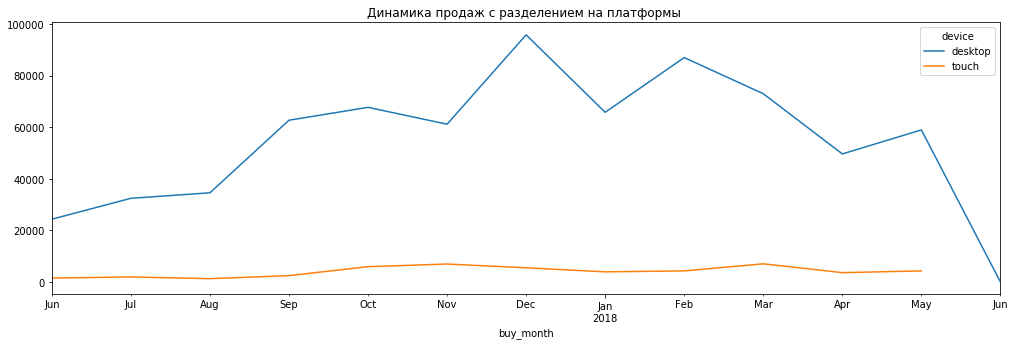

In [50]:
#построим на графике динамику продаж с разделением по платформам
purchase_by_month_pivot.plot(figsize = (17,5), title = 'Динамика продаж с разделением на платформы ')

#### Вывод:

- Обычно пользователи совершают 1 заказ
- Но если смотреть на покупки за год, то видно, что увеличивается значение повторных покупок
- Динамика покупок подтверждает сезонность, выявленную ранее
- Стационарные устройства значительно популярнее мобильных при просмотре Яндекс.Афиши

- **Какой средний чек?**

In [51]:
#покупок мало, сделаем когортный анализ по количеству покупок на человека - когорты выведем по дате первой сессии
orders = orders[['uid', 'revenue', 'buy_ts', 'buy_month', 'first_buy_ts', 'first_buy_month', 'first_session_month']]
display(orders)

,uid,revenue,buy_ts,buy_month,first_buy_ts,first_buy_month,first_session_month
0,10329302124590727494,17.00,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,11627257723692907447,0.55,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,17903680561304213844,0.37,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,16109239769442553005,0.55,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,14200605875248379450,0.37,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01
...,...,...,...,...,...,...,...
50410,12296626599487328624,4.64,2018-05-31 23:50:00,2018-05-01,2018-05-31 23:50:00,2018-05-01,2018-05-01
50411,11369640365507475976,5.80,2018-05-31 23:50:00,2018-05-01,2018-05-31 23:50:00,2018-05-01,2018-05-01
50412,1786462140797698849,0.30,2018-05-31 23:54:00,2018-05-01,2018-05-31 23:54:00,2018-05-01,2018-05-01
50413,3993697860786194247,3.67,2018-05-31 23:56:00,2018-05-01,2018-05-31 23:56:00,2018-05-01,2017-10-01


In [52]:
#вынесем месяц покупки в отдельный столбец
orders['buy_month'] = pd.to_datetime(orders['buy_month'], format="%Y-%m-%d %H:%M:%S")

#изменим тип данных
orders['buy_month']=orders['buy_month'].astype('datetime64[M]')

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 7 columns):
uid                    50415 non-null uint64
revenue                50415 non-null float64
buy_ts                 50415 non-null datetime64[ns]
buy_month              50415 non-null datetime64[ns]
first_buy_ts           50415 non-null datetime64[ns]
first_buy_month        50415 non-null datetime64[ns]
first_session_month    50415 non-null datetime64[ns]
dtypes: datetime64[ns](5), float64(1), uint64(1)
memory usage: 2.7 MB


In [53]:
#посчитаем lifetime заказов
orders['lifetime_orders'] = \
            ((orders.loc[:,'buy_month'] - orders.loc[:,'first_buy_month']) / np.timedelta64(1, 'M'))\
            .round().astype('int')

#посмотрим есть ли пропуски
orders['lifetime_orders'].isnull().sum()

0

In [54]:
#сгруппируем заказы по когортам и lifetime и высчитаем кол-во покупок и пользователей
orders_grouped_by_cohorts = \
                orders.groupby(['first_session_month', 'lifetime_orders']).agg({'uid':['count', 'nunique']}).reset_index()

#изменим названия столбцов
orders_grouped_by_cohorts.columns = ['first_session_month', 'lifetime_orders', 'n_orders', 'n_users']

#получим количество заказов на одного пользователя по каждой когорте и каждому lifetime
orders_grouped_by_cohorts['orders_per_user'] = \
                orders_grouped_by_cohorts['n_orders'] / orders_grouped_by_cohorts['n_users']

orders_grouped_by_cohorts['first_session_month'] = \
                orders_grouped_by_cohorts['first_session_month'].dt.strftime('%Y-%m')

#создадим сводную таблицу с когортным анализом количества заказов на пользователя 
cohorts = orders_grouped_by_cohorts\
        .pivot_table(index = 'first_session_month', columns = 'lifetime_orders', values = 'orders_per_user', aggfunc = 'mean')

#добавим среднее
cohorts['mean'] = cohorts.mean(axis=1)

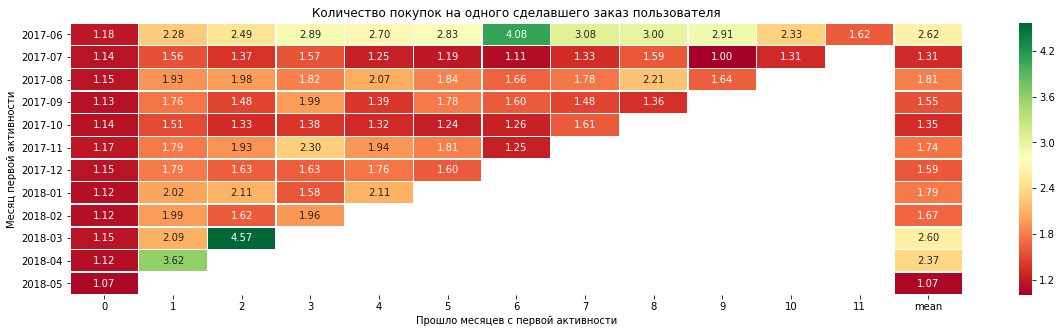

In [55]:
plt.figure(figsize=(20, 5))
plt.title('Количество покупок на одного сделавшего заказ пользователя')
sns.heatmap(cohorts, annot=True, fmt=".2f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Прошло месяцев с первой активности')
plt.ylabel('Месяц первой активности')
plt.show()

Text(113.99999999999999, 0.5, 'Месяц первой активности')

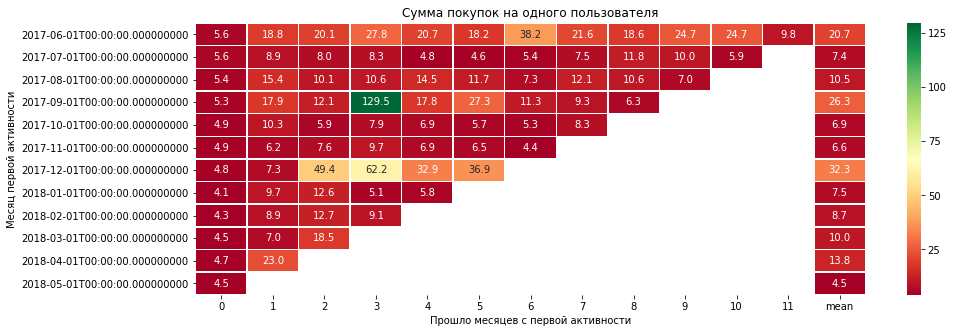

In [56]:
#сгруппируем заказы по когортам и lifetime и суммам покупок на одного пользователя
orders_grouped_by_cohorts = orders\
    .groupby(['first_session_month', 'lifetime_orders']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
orders_grouped_by_cohorts.columns = ['first_session_month', 'lifetime_orders', 'revenue_total', 'n_users']
orders_grouped_by_cohorts['revenue_per_user'] = \
        orders_grouped_by_cohorts['revenue_total'] / orders_grouped_by_cohorts['n_users']


#создадим сводную таблицу с когортным анализом суммы покупок на пользователя 
cohorts_revenue_per_user = orders_grouped_by_cohorts\
    .pivot_table(index = 'first_session_month', columns = 'lifetime_orders', values = 'revenue_per_user', aggfunc = 'mean')
cohorts_revenue_per_user['mean'] = cohorts_revenue_per_user.mean(axis=1)

#построим график
plt.figure(figsize=(15, 5))
plt.title('Сумма покупок на одного пользователя')
sns.heatmap(cohorts_revenue_per_user, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Прошло месяцев с первой активности')
plt.ylabel('Месяц первой активности')

In [57]:
#найднем среднюю сумму покупок по когортам
mean_revenue_cohorts = orders.groupby(['first_buy_month', 'lifetime_orders'])\
        .agg({'revenue':'sum', 'uid':'nunique', 'buy_ts': 'count'}).reset_index()
mean_revenue_cohorts.columns = ['first_buy_month', 'lifetime_orders', 'revenue_total', 'n_users', 'n_orders']
mean_revenue_cohorts['mean_revenue'] = mean_revenue_cohorts['revenue_total'] / mean_revenue_cohorts['n_orders']

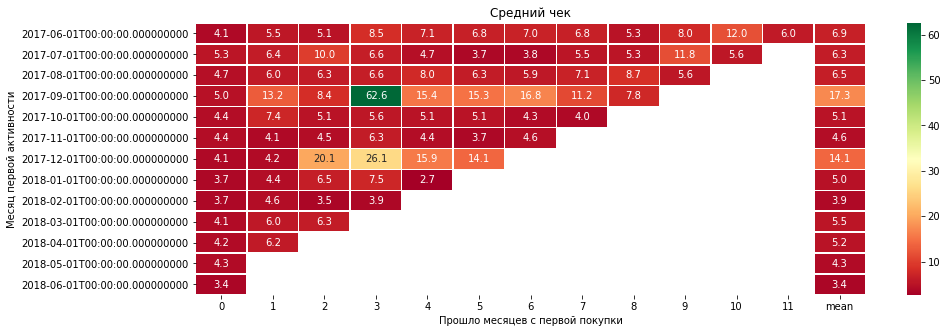

In [58]:
#построим сводную таблицу
cohorts_revenue_per_order = mean_revenue_cohorts\
            .pivot_table(index = 'first_buy_month', columns = 'lifetime_orders', values = 'mean_revenue')

#добавим среднее
cohorts_revenue_per_order['mean'] = cohorts_revenue_per_order.mean(axis=1)

#построим график
plt.figure(figsize=(15, 5))
plt.title('Cредний чек')
sns.heatmap(cohorts_revenue_per_order, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Прошло месяцев с первой покупки')
plt.ylabel('Месяц первой активности');

In [59]:
#построим на динамику среднего чека
dynamic_revenue_per_order = orders.groupby(['buy_month', 'lifetime_orders']).agg({'revenue':'sum', 'buy_ts': 'count'}).reset_index()
dynamic_revenue_per_order.columns = ['buy_month', 'lifetime_orders', 'revenue_total', 'n_orders']
dynamic_revenue_per_order

,buy_month,lifetime_orders,revenue_total,n_orders
0,2017-06-01,0,"9,557.49",2354
1,2017-07-01,0,"11,557.65",2186
2,2017-07-01,1,981.82,177
3,2017-08-01,0,"7,228.83",1533
4,2017-08-01,1,644.61,100
...,...,...,...,...
74,2018-05-01,8,474.92,61
75,2018-05-01,9,257.53,46
76,2018-05-01,10,299.36,53
77,2018-05-01,11,519.62,86


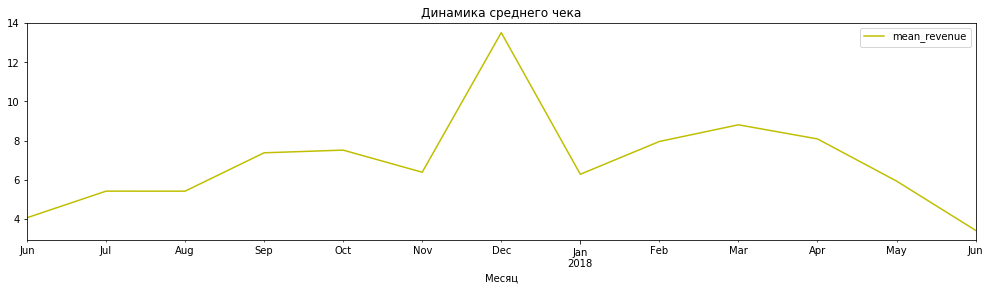

In [60]:
#добавим столбец с средним чеком
dynamic_revenue_per_order['mean_revenue'] = \
        dynamic_revenue_per_order['revenue_total'] / dynamic_revenue_per_order['n_orders']

#строим сводную таблицу
dynamic_revenue_mean = dynamic_revenue_per_order\
        .pivot_table(index='buy_month', values='mean_revenue')

#строи мграфик
dynamic_revenue_mean.plot(title='Динамика среднего чека', color='y', figsize=(17,4))
plt.xlabel('Месяц')
plt.show()

In [61]:
#print('Средний чек равен {:.2f}'.format(dynamic_revenue_per_order['mean_revenue'].mean()))

print('Средний чек равен {:.2f}'.format(orders['revenue'].mean()))

Средний чек равен 5.00


**Вывод:**

- Средний чек равен 5.00
- С ноября по февраль увеличенный средний чек, видимо это связано с Новым годом и количеством премьер новых фильмов в этот период.
- Средний чек по когортам со временем увеличивается

- **Сколько денег приносят? (LTV)**

In [62]:
#cделаем когорты по Lifetime и первому месяцу заказа
orders['age_cohort'] = ((orders['buy_month'] - orders['first_buy_month']) / np.timedelta64(1, 'M')).round().astype('int')
cohort_sizes_ltv = orders.groupby('first_buy_month').agg({'uid':'nunique'})
cohort_sizes_ltv.columns = ['cohort_size']

orders_grouped_by_cohorts_ltv = orders.groupby(['first_buy_month', 'age_cohort'])\
                                .agg({'revenue':'sum', 'uid':'nunique'}).reset_index()

orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv.join(cohort_sizes_ltv, on='first_buy_month')
orders_grouped_by_cohorts_ltv['ltv'] = orders_grouped_by_cohorts_ltv['revenue'] / orders_grouped_by_cohorts_ltv['cohort_size']
orders_grouped_by_cohorts_ltv['revenue_per_user'] = orders_grouped_by_cohorts_ltv['revenue'] / orders_grouped_by_cohorts_ltv['uid']

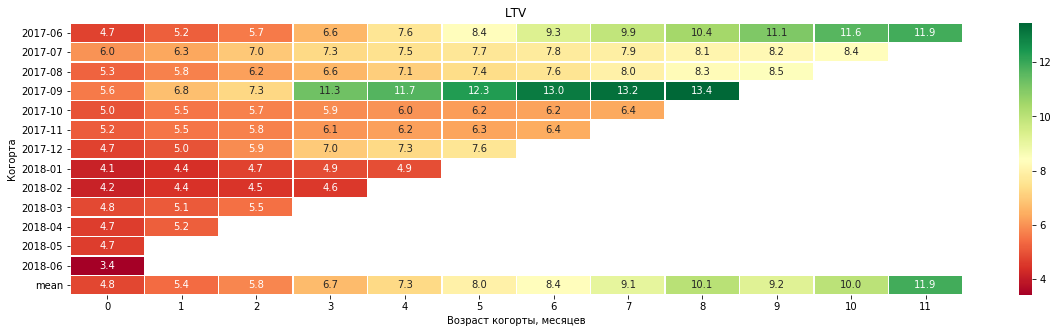

In [63]:
#посчитаем LTV по когортам
ltv = orders_grouped_by_cohorts_ltv\
            .pivot_table(index = 'first_buy_month', columns = 'age_cohort', values = 'ltv', aggfunc = 'mean')
ltv = ltv.cumsum(axis = 1)
ltv = ltv.reset_index()
ltv['first_buy_month'] = ltv['first_buy_month'].dt.strftime('%Y-%m')
ltv = ltv.set_index('first_buy_month')
ltv.loc['mean'] = ltv.mean()
ltv = ltv.round(2)

#построим тепловую карту
plt.figure(figsize=(20, 5))
plt.title('LTV')
sns.heatmap(ltv, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Возраст когорты, месяцев')
plt.ylabel('Когорта')
plt.show()

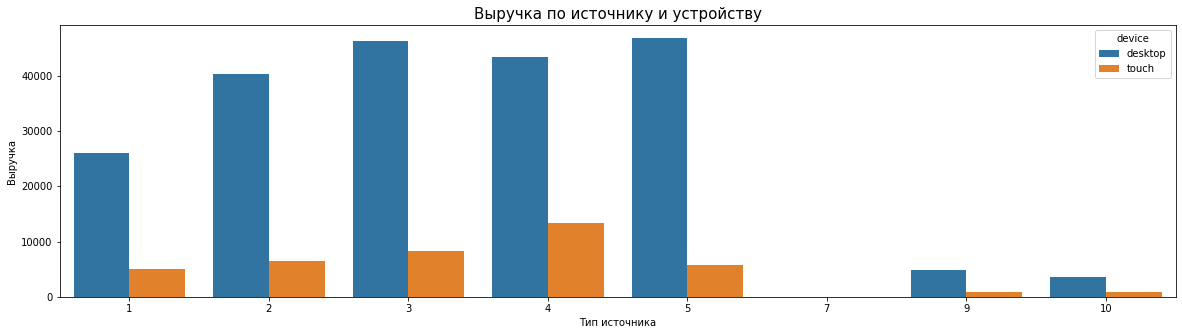

In [64]:
#посмотрим на выручку с разделением на платформы
visits_by_source = visits.query('start_ts == first_visit')
revenue_by_source_and_device = (orders.merge(visits_by_source, on='uid', how='inner'))\
                                .groupby(['source_id', 'device']).agg({'revenue':'sum'})

#сбросим мультииндекс
revenue_by_source_and_device = revenue_by_source_and_device.reset_index()

#построим график
plt.figure(figsize = (20, 5))
ax = sns.barplot(x="source_id", y="revenue", hue="device", data=revenue_by_source_and_device)
plt.title('Выручка по источнику и устройству', size='15')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Выручка')
plt.show()

### Маркетинг

- **Сколько денег потратили? Всего / на каждый источник / по времени**

In [65]:
print('Всего потратили:',costs['costs'].sum())

Всего потратили: 329131.62


In [66]:
#сгруппируем по источникам и затратам
cost_source = costs.groupby('source_id')['costs'].sum().reset_index()

#сделаем столбец с процентными затратами
cost_source['percents'] = (cost_source['costs'] / costs['costs'].sum()) * 100

#посмотрим расходы по источникам
cost_source.sort_values('percents', ascending = False)

,source_id,costs,percents
2,3,"141,321.63",42.94
3,4,"61,073.60",18.56
4,5,"51,757.10",15.73
1,2,"42,806.04",13.01
0,1,"20,833.27",6.33
6,10,"5,822.49",1.77
5,9,"5,517.49",1.68


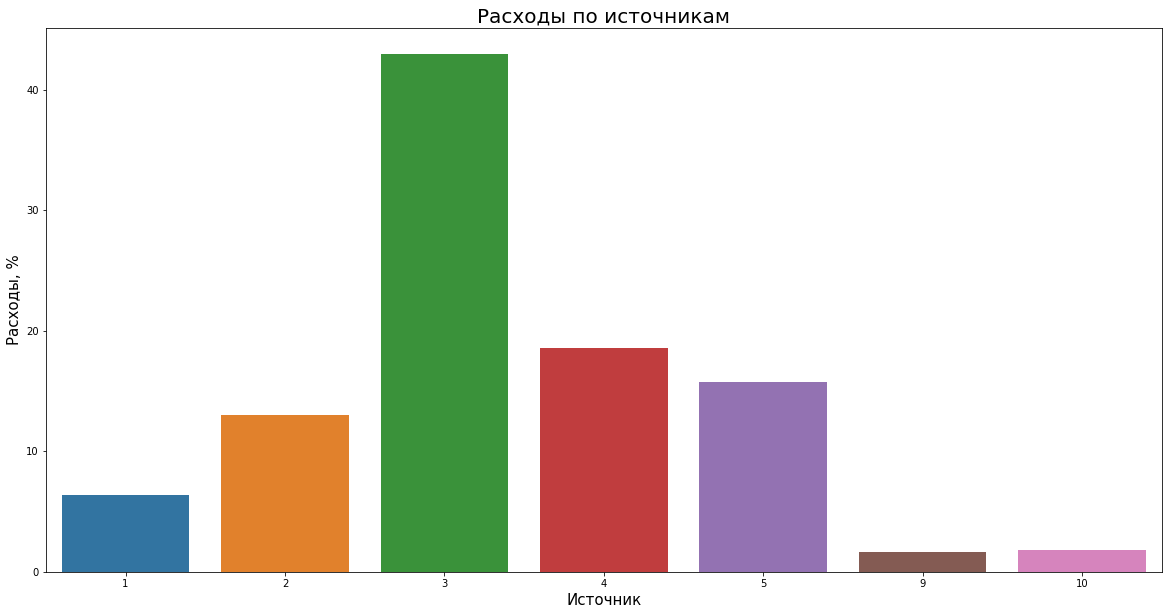

In [67]:
#построим барплот
plt.figure(figsize = (20, 10))
ax = sns.barplot(x="source_id", y="percents", data=cost_source)
plt.title('Расходы по источникам', size='20')
ax.set_xlabel('Источник', size='15')
ax.set_ylabel('Расходы, %', size='15')
plt.show()

In [68]:
costs.head(1)

,source_id,dt,costs
0,1,2017-06-01,75.20


In [69]:
#сделаем столбец с месяцем и названием
costs['costs_month'] = costs['dt'].astype('datetime64[M]').dt.date

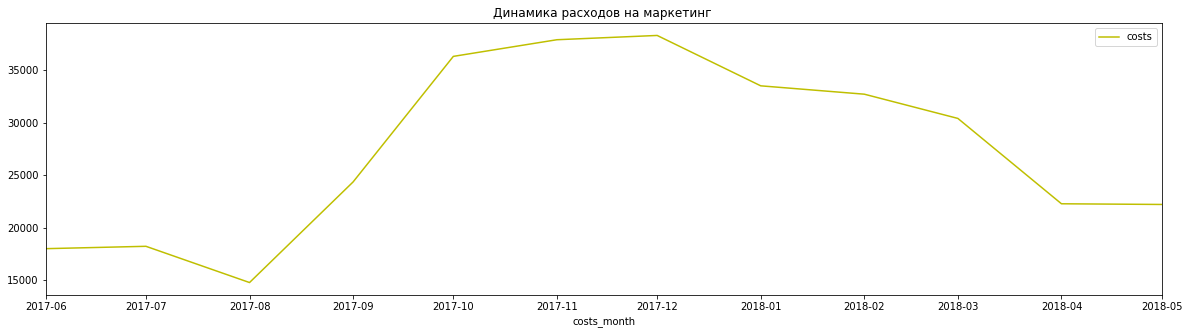

In [70]:
#посмотрим общую динамику расходов на маркетинг
costs_by_month_total = costs.groupby('costs_month')['costs'].sum().reset_index() 
costs_by_month_total_pivot =costs_by_month_total.pivot_table(index='costs_month', values='costs')
costs_by_month_total_pivot.plot(figsize=(20, 5), color='y', title='Динамика расходов на маркетинг ');

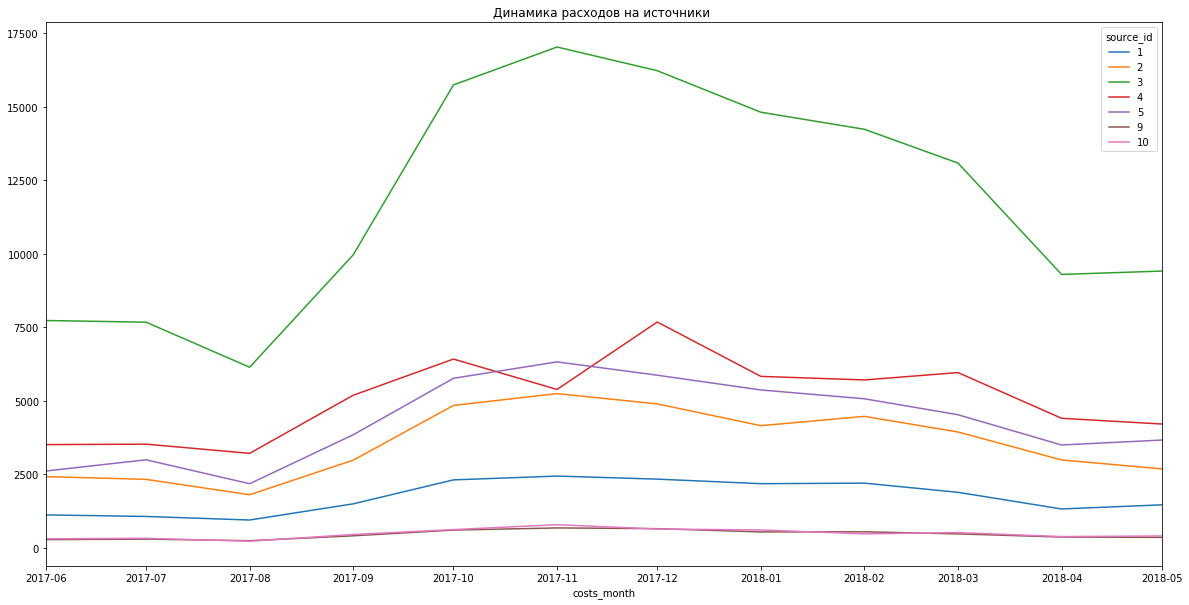

In [71]:
#также посмотрим на динамику расходов с разделением на источники
costs_by_month = costs.groupby(['costs_month','source_id'])['costs'].sum().reset_index() 
costs_by_month_pivot = costs_by_month.pivot_table(index='costs_month', columns='source_id', values='costs')
costs_by_month_pivot.plot(figsize = (20,10), title = 'Динамика расходов на источники ');

#### Вывод:

- Всего потратили - 329131.62
- Самый дорогой источник - 3 (43% всех расходов на маркетинг), 141321.63
- Период наивысших трат - Октябрь-Январь

- **Сколько стоило привлечение одного покупателя из каждого источника?** 

In [78]:
#составим таблицу по количеству покупателей, в разрезе источников и месяцев
users = visits[['uid', 'source_id', 'start_ts', 'first_visit_month']]

first_visit = visits.groupby('uid', as_index = False)['start_ts'].min()
first_visit.columns = ['uid', 'first_order_time']

users = users.merge(first_visit, on = 'uid')
users = users[users['start_ts'] == users['first_order_time']]
users = users.merge(orders.groupby('uid', as_index = False)['revenue'].sum(), on = 'uid', how = 'left')
users = users.dropna().reset_index(drop = True)
users

,uid,source_id,start_ts,first_visit_month,first_order_time,revenue
0,16174680259334210214,4,2018-03-09 20:05:00,2018-03-01,2018-03-09 20:05:00,2.33
1,16007536194108375387,5,2017-09-03 21:35:00,2017-09-01,2017-09-03 21:35:00,5.50
2,8056418121947262981,2,2017-06-04 14:17:00,2017-06-01,2017-06-04 14:17:00,466.57
3,18188358787673499603,3,2018-02-10 12:17:00,2018-02-01,2018-02-10 12:17:00,0.79
4,2307401184189569202,4,2017-09-23 23:27:00,2017-09-01,2017-09-23 23:27:00,3.67
...,...,...,...,...,...,...
36518,6752020629696526518,3,2017-12-04 12:42:00,2017-12-01,2017-12-04 12:42:00,4.15
36519,11750532881998794555,4,2017-11-20 23:33:00,2017-11-01,2017-11-20 23:33:00,3.67
36520,11202626539189016002,4,2017-11-29 20:27:00,2017-11-01,2017-11-29 20:27:00,3.05
36521,12734910664455613822,10,2018-04-23 21:11:00,2018-04-01,2018-04-23 21:11:00,0.49


In [79]:
#изменим тип данных в столбце costs_month на datetime
costs['costs_month'] = costs['costs_month'].astype('datetime64[M]')

In [80]:
#теперь формируем таблицу cac по источникам
sources = users.groupby(['source_id', 'first_visit_month'], as_index = False)\
                .agg({'uid':'count', 'revenue':'sum'})

sources.columns = ['source_id', 'costs_month', 'users', 'revenue']

sources = sources\
        .merge(costs.groupby(['source_id', 'costs_month'], as_index = False)['costs'].sum(), on = ['source_id', 'costs_month'])

sources['cac'] = sources['costs'] / sources['users']

In [81]:
sources

,source_id,costs_month,users,revenue,costs,cac
0,1,2017-06-01,240,"9,910.69","1,125.61",4.69
1,1,2017-07-01,184,"2,341.21","1,072.88",5.83
2,1,2017-08-01,126,"2,624.27",951.81,7.55
3,1,2017-09-01,248,"2,414.97","1,502.01",6.06
4,1,2017-10-01,350,"3,252.30","2,315.75",6.62
...,...,...,...,...,...,...
79,10,2018-01-01,103,369.68,614.35,5.96
80,10,2018-02-01,113,261.92,480.88,4.26
81,10,2018-03-01,166,545.28,526.41,3.17
82,10,2018-04-01,98,258.70,388.25,3.96


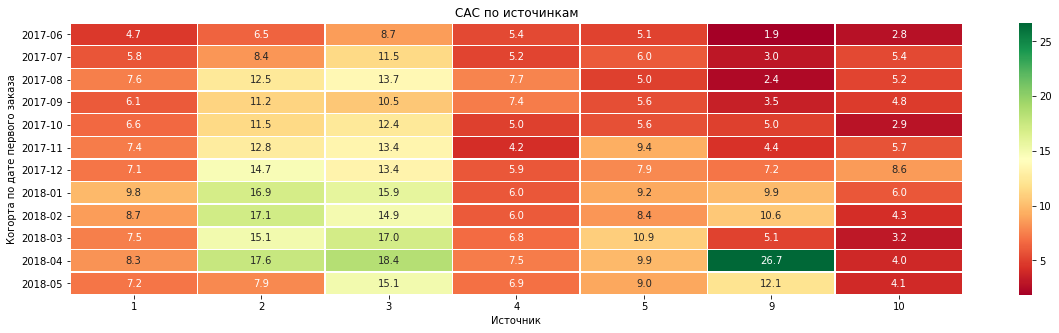

In [82]:
#визуализируем
sources_pivot = sources.pivot_table(index='costs_month', columns='source_id', values='cac', aggfunc = 'sum')
sources_pivot.index = sources_pivot.index.strftime('%Y-%m')

plt.figure(figsize=(20, 5))
plt.title('САС по источинкам')
sns.heatmap(sources_pivot, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Источник')
plt.ylabel('Когорта по дате первого заказа')
plt.show()

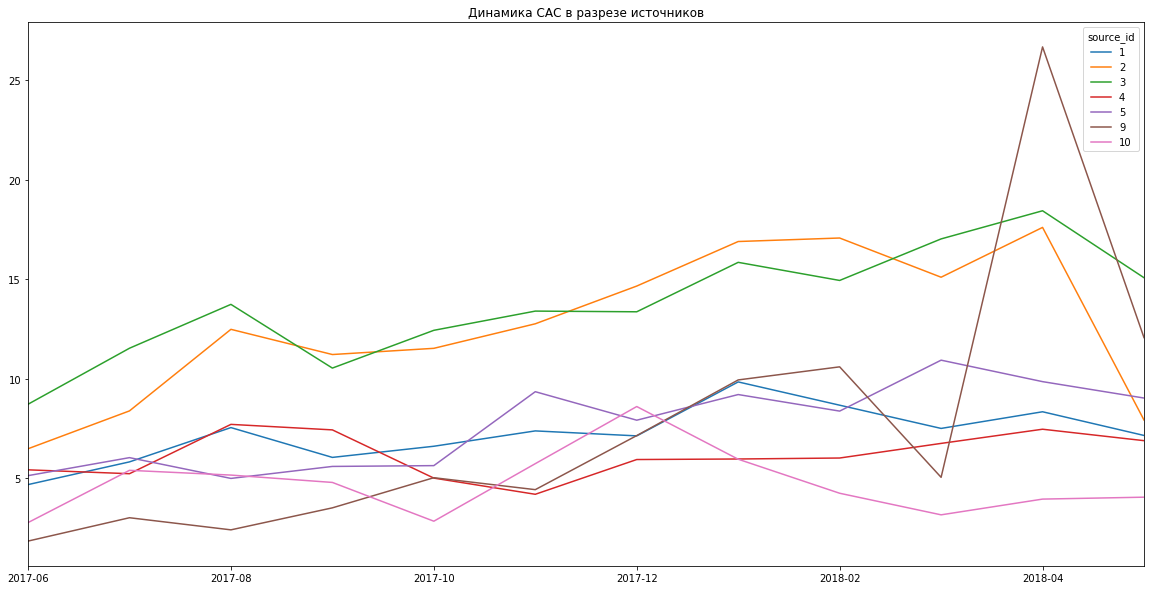

In [83]:
sources_pivot.plot(figsize = (20,10), title = 'Динамика САС в разрезе источников')

**Вывод:**

- Источники  2, 3 - на него уходят основные деньги маркетинга, а стоимость привлечения самая высокая.
- При этом средний чек - 5
- Если исходить из положительной разницы среднего чека и стоимости привлечения клиента - реклама в источниках 2 и 3 не окупается.

- **На сколько окупились расходы? (ROI)**

In [84]:
#посмотрим выручку по источникам
revenue_by_source = (orders.merge(visits_by_source, on='uid', how='inner'))\
                    .groupby('source_id').agg({'revenue':'sum'}).reset_index()
revenue_by_source

,source_id,revenue
0,1,"31,090.55"
1,2,"46,923.61"
2,3,"54,511.24"
3,4,"56,696.83"
4,5,"52,624.02"
5,7,1.22
6,9,"5,759.40"
7,10,"4,450.33"


In [85]:
#создадим переменнуб рои и смержим таблицы
roi = revenue_by_source.merge(cost_source, on='source_id')

#посчитаем рои в отдельный столбец
roi['roi'] = (roi['revenue'] - roi['costs']) / roi['costs']

#смотрим
roi.sort_values('roi', ascending = False)

,source_id,revenue,costs,percents,roi
0,1,"31,090.55","20,833.27",6.33,0.49
1,2,"46,923.61","42,806.04",13.01,0.10
5,9,"5,759.40","5,517.49",1.68,0.04
4,5,"52,624.02","51,757.10",15.73,0.02
3,4,"56,696.83","61,073.60",18.56,-0.07
6,10,"4,450.33","5,822.49",1.77,-0.24
2,3,"54,511.24","141,321.63",42.94,-0.61


In [86]:
roi.revenue.sum()

252055.98000000563

In [87]:
#построим сводную таблицу
roi_pivot = roi.pivot_table(index='source_id', values='roi').sort_values(by='roi', ascending=False)
roi_pivot

,roi
source_id,
1,0.49
2,0.10
9,0.04
5,0.02
4,-0.07
10,-0.24
3,-0.61


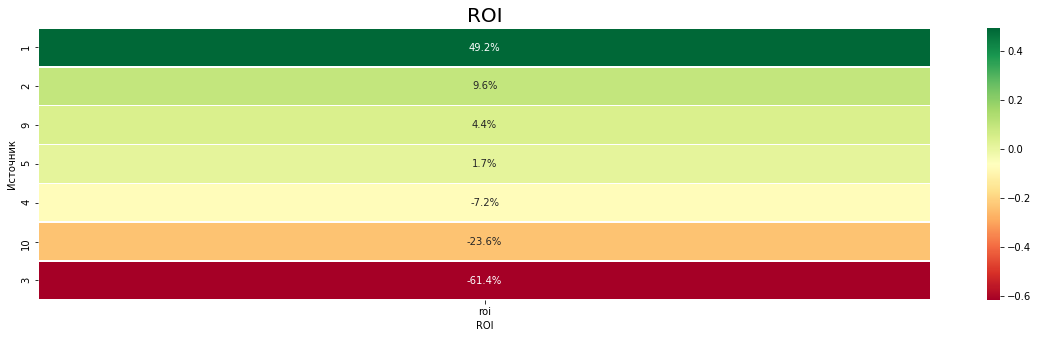

In [88]:
#построим график
plt.figure(figsize=(20, 5))
plt.title('ROI', size='20')
sns.heatmap(roi_pivot, annot=True, fmt=".1%", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('ROI', size='10')
plt.ylabel('Источник', size='10')
plt.show()

#### Построим на окупаемость по когортам

In [89]:
orders_grouped_by_cohorts_ltv

,first_buy_month,age_cohort,revenue,uid,cohort_size,ltv,revenue_per_user
0,2017-06-01,0,"9,557.49",2023,2023,4.72,4.72
1,2017-06-01,1,981.82,61,2023,0.49,16.10
2,2017-06-01,2,885.34,50,2023,0.44,17.71
3,2017-06-01,3,"1,931.30",54,2023,0.95,35.76
4,2017-06-01,4,"2,068.58",88,2023,1.02,23.51
...,...,...,...,...,...,...,...
74,2018-03-01,2,"1,114.87",58,3533,0.32,19.22
75,2018-04-01,0,"10,600.69",2276,2276,4.66,4.66
76,2018-04-01,1,"1,209.92",69,2276,0.53,17.54
77,2018-05-01,0,"13,925.76",2988,2988,4.66,4.66


In [90]:
visits

,device,end_ts,source_id,start_ts,uid,session_date,session_week,session_month,session_year,session_duration,first_visit,first_visit_month,visit_month,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,10,3,2018,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-23,17,4,2018,480,2018-04-23 21:11:00,2018-04-01,2018-04-01,0
359396,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017-11-08,45,11,2017,0,2017-11-08 13:39:00,2017-11-01,2017-11-01,0
359397,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,2017-07-31,31,7,2017,1080,2017-07-31 12:13:00,2017-07-01,2017-07-01,0
359398,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,272012551460639309,2018-03-20,12,3,2018,840,2018-03-20 15:11:00,2018-03-01,2018-03-01,0


In [105]:
# определяем источник пользователя
sources2 = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})

# соединяем первые покупки и источники 
payers = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(sources2, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})

# считаем ltv
ltv2 = payers.merge(orders, on = 'uid')
ltv2['lifetime'] = ((ltv2['buy_ts'] - ltv2['first_buy']) / np.timedelta64(1,'M')).round().astype(int)
ltv2
orders_lifetime = ltv2.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'count').fillna(0)
buyers_lifetime = ltv2.pivot_table(index = 'source_id', columns = 'lifetime', values = 'uid', aggfunc = 'nunique').fillna(0)
ltv2 = ltv2.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
ltv2 = ltv2.cumsum(axis = 1)

# добавляем размеры когорт и делим на них
cohort_sizes = payers.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})
ltv2 = ltv2.merge(cohort_sizes, on = 'source_id')
ltv2 = ltv2.div(ltv2['cohort_size'], axis = 0).drop(columns = 'cohort_size')

display(ltv)
# считаем САС
cac2 = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index().merge(cohort_sizes.reset_index(), left_on = 'source_id', right_on='source_id')
cac2['cac'] = cac2['costs'] / cac2['cohort_size']
cac2 = cac2.set_index('source_id')
display(cac2)

# считаем ROMI
romi2 = ltv2.merge(cac2[['cac']], on = 'source_id')
romi2 = romi2.div(romi2['cac'], axis = 0).drop(columns = 'cac')
display(romi2)

age_cohort,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,4.72,5.21,5.65,6.60,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07,6.01,6.35,6.97,7.33,7.50,7.66,7.78,7.92,8.08,8.23,8.39,nan
2017-08,5.28,5.75,6.21,6.60,7.09,7.38,7.59,7.99,8.28,8.47,nan,nan
2017-09,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,nan,nan,nan
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,nan,nan,nan,nan
2017-11,5.15,5.55,5.75,6.08,6.23,6.28,6.40,nan,nan,nan,nan,nan
2017-12,4.74,5.00,5.92,6.99,7.30,7.64,nan,nan,nan,nan,nan,nan
2018-01,4.14,4.43,4.73,4.88,4.94,nan,nan,nan,nan,nan,nan,nan
2018-02,4.16,4.44,4.51,4.59,nan,nan,nan,nan,nan,nan,nan,nan


,costs,cohort_size,cac
source_id,,,
1,"20,833.27",2899,7.19
2,"42,806.04",3506,12.21
3,"141,321.63",10473,13.49
4,"61,073.60",10296,5.93
5,"51,757.10",6931,7.47
9,"5,517.49",1088,5.07
10,"5,822.49",1329,4.38


,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,0.86,1.00,1.10,1.19,1.26,1.29,1.33,1.37,1.42,1.45,1.47,1.49,1.49
2,0.55,0.66,0.80,0.92,0.97,1.02,1.04,1.06,1.08,1.08,1.09,1.10,1.10
3,0.33,0.35,0.36,0.37,0.38,0.38,0.38,0.38,0.38,0.39,0.39,0.39,0.39
4,0.77,0.80,0.82,0.83,0.85,0.88,0.90,0.91,0.91,0.92,0.93,0.93,0.93
5,0.66,0.68,0.73,0.92,0.95,0.97,0.99,1.00,1.01,1.01,1.02,1.02,1.02
9,0.77,0.82,0.87,0.92,0.94,0.97,1.00,1.01,1.03,1.04,1.04,1.04,1.04
10,0.72,0.74,0.74,0.75,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76,0.76


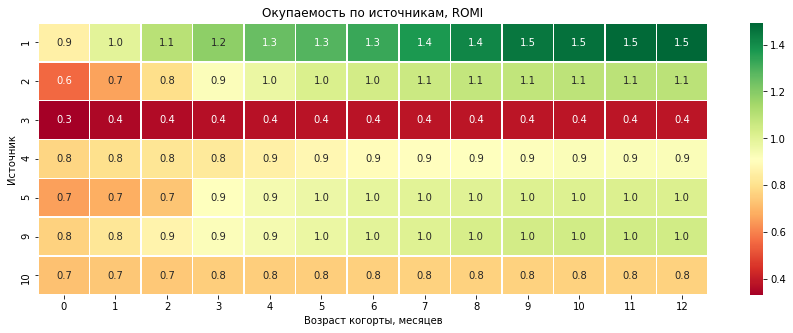

In [108]:
#строим график
plt.figure(figsize=(15, 5))
plt.title('Окупаемость по источникам, ROMI')
sns.heatmap(romi2, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Возраст когорты, месяцев')
plt.ylabel('Источник')
plt.show()

#### Вывод: 

Источники:

1.Окупился с 2 месяца и начал приносить прибыль с 3 месяца, самый перспективный источник в который необходимо вкладываться

2.Окупился с 5 месяца, но начал приносить прибыль с 8 месяца.

3.Не окупился

4.Не окупился

5.Окупился с 6 месяца, но прибыли так и не принес

9.Окупился с 6 месяца, но прибыли так и не принес

10.Не окупился

In [103]:
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv.set_index('first_buy_month')
costs_by_month = costs.pivot_table(index = 'costs_month', values = 'costs', aggfunc = 'sum').reset_index()
costs_by_month.columns = ['first_buy_month', 'costs']
costs_by_month['first_buy_month'] = pd.to_datetime(costs_by_month['first_buy_month'], format = '%Y.%m.%d')
costs_by_month = costs_by_month.set_index('first_buy_month')
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv.join(costs_by_month, on = 'first_buy_month')
orders_grouped_by_cohorts_ltv['cac'] = orders_grouped_by_cohorts_ltv['costs'] / orders_grouped_by_cohorts_ltv['cohort_size']
orders_grouped_by_cohorts_ltv['romi'] = orders_grouped_by_cohorts_ltv['ltv'] / orders_grouped_by_cohorts_ltv['cac']
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv[:-1]
orders_grouped_by_cohorts_ltv = orders_grouped_by_cohorts_ltv.reset_index()

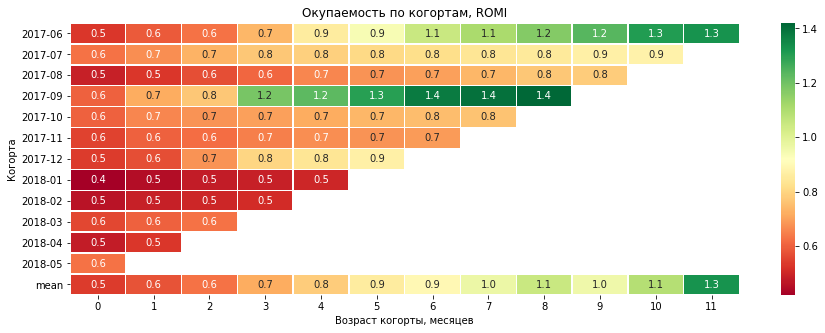

In [104]:
#строим сводную таблицу
romi = orders_grouped_by_cohorts_ltv\
            .pivot_table(index = 'first_buy_month', columns = 'age_cohort', values = 'romi', aggfunc = 'mean')

romi = romi.cumsum(axis=1)
romi = romi.reset_index()
romi['first_buy_month'] = romi['first_buy_month'].dt.strftime('%Y-%m')
romi = romi.set_index('first_buy_month')
romi.loc['mean'] = romi.mean()
romi = romi.round(2)

#строим график
plt.figure(figsize=(15, 5))
plt.title('Окупаемость по когортам, ROMI')
sns.heatmap(romi, annot=True, fmt=".1f", linewidths=.5, cmap = 'RdYlGn')
plt.xlabel('Возраст когорты, месяцев')
plt.ylabel('Когорта')
plt.show()

**Вывод:**
    
- В среднем окупаемость по когортам начинается не ранее 7 месяца их жизни.
- Необходимо отдельно изучить сентябрьскую когорту, 20% прибыли уже на 4-ый месяц

## Шаг 3. Общий вывод

# Продукт

### Сколько людей пользуются в день, неделю, месяц?

**По всем типам устройств:**

- Количество пользователей в день: 907
- Количество пользователей в неделю: 5825
- Количество пользователей в месяц: 23228

- Процесс вовлеченности аудитории за неделю: 15.59%
- Процесс вовлеченности аудитории за месяц: 3.91%

**В разрезе разных устройств:**

_Пользователи компьютеров:_

- Количество пользователей в день: 659
- Количество пользователей в неделю: 4208
- Количество пользователей в месяц: 16724

_Пользователи мобильных устройств:_

- Количество пользователей в день: 252
- Количество пользователей в неделю: 1666
- Количество пользователей в месяц: 6825

_Пользователи компьютеров:_

- Процесс вовлеченности аудитории за неделю: 15.67%
- Процесс вовлеченности аудитории за месяц: 3.94%

_Пользователи мобильных устройств:_

- Процесс вовлеченности аудитории за неделю: 15.18%
- Процесс вовлеченности аудитории за месяц: 3.70%

**В целом могу выделить следующее:**

1. Есть сезонность и люди используют Яндекс.Афишу больше всего в период осени-зимы
2. Пользователей с компьютеров больше в 3 раза чем пользователесь с мобильных устройств
3. В декабре есть период аномальной активности, нужно сообщить отделу маркетинга, что бы они его проверили

### Сколько сессий в день:

- Сессий в день в среднем: 987

### Сколько длиться сессия?

- Мода одной сессии составляет 60 секунд, считаю это не большим показателям, необходимо об этом сообщить маркетингу.

### Как часто люди возвращаются?

- После первого месяца использования очень мало людей продолжают использовать на ежемесячной основе.
- Возвращается очень маленький процент людей и с течением времени он падает.

# Продажи

### Когда люди начинают покупать?

- Медиана времени первой покупки: 16 минут
- Среднее времени первой покупки: 16 дней
- Мода времени первой покупки: 1 минута
    
Покупки как правило совершают после 1 сессии.

### Сколько раз покупают за период?

- Обычно пользователи совершают 1 заказ
- Но если смотреть на покупки за год, то видно, что увеличивается значение повторных покупок
- Динамика покупок подтверждает сезонность, выявленную ранее
- Стационарные устройства значительно популярнее мобильных при просмотре Яндекс.Афиши

### Какой средний чек?

- Средний чек равен 5.00
- С ноября по февраль увеличенный средний чек, видимо это связано с Новым годом и количеством премьер новых фильмов в этот период.
- Средний чек по когортам со временем увеличивается

### Сколько денег приносят? LTV

- LTV одного клиента на первый месяц составляет 4,92
- В течение года данный показатель в среднем увеличивается в 2 раза
- Выручка по пользователям стационарных устройств значительно выше

# Маркетинг

### Сколько денег потратили? Всего / на каждый источник / по времени

- Всего потратили - 329131.62
- Самый дорогой источник - 3 (43% всех расходов на маркетинг), 141321.63
- Период наивысших трат - Октябрь-Январь

### Сколько стоило привлечение одного покупателя из каждого источника?

- Источник 3 = 13.79 - на него уходят основные деньги маркетинга, а стоимость привлечения самая высокая.
- При этом средний чек - 5.00
- Если исходить из положительной разницы среднего чека и стоимости привлечения клиента - реклама в источниках 2 и 3 не окупается.

### На сколько окупились расходы? (ROI)

#### Источник 1:

- Выручка - 31,090.55
- Затраты - 20,833.27
- Окупаемость инвестиций (ROI) - 49%

#### Источник 2:

- Выручка - 46,923.61
- Затраты - 42,806.04
- Окупаемость инвестиций (ROI) - 10%

#### Источник 3:

- Выручка - 54,511.24
- Затраты - 141,321.63
- Окупаемость инвестиций (ROI) - 61%

#### Источник 4:

- Выручка - 56,696.83
- Затраты - 61,073.60
- Окупаемость инвестиций (ROI) - 7%

#### Источник 5:

- Выручка - 52,624.02
- Затраты - 51,757.10
- Окупаемость инвестиций (ROI) - 2%

#### Источник 7:

- Выручка - 1,22
- Затраты - 0
- Окупаемость инвестиций (ROI) - 0%

#### Источник 9:

- Выручка - 5,759.40
- Затраты - 5,517.49
- Окупаемость инвестиций (ROI) - 4%

#### Источник 10:

- Выручка - 4,450.33
- Затраты - 5,822.49
- Окупаемость инвестиций (ROI) - 24%

### ROMI:
#### Источники:

1.Окупился с 2 месяца и начал приносить прибыль с 3 месяца, самый перспективный источник в который необходимо вкладываться

2.Окупился с 5 месяца, но начал приносить прибыль с 8 месяца.

3.Не окупился

4.Не окупился

5.Окупился с 6 месяца, но прибыли так и не принес

9.Окупился с 6 месяца, но прибыли так и не принес

10.Не окупился

**Также стоит учитывать:**

- В среднем окупаемость по когортам начинается не ранее 7 месяца их жизни.
- Есть отдельные когорта 2017-09, положительные показатели уже на 4-ый месяц.

# Куда и сколько стоит вкладывать денег?

### Текущая экономика по маркетингу отрицательная

Видно, что наибольшие затраты - вложение в источник 3 (Почти 43% всего бюджета на маркетинг, при самом дорогом САС - 13,49) от этого источника следует отказаться, либо оптимизировать расходы по нему.

- Общая выручка - 250177.36
- Общие затраты: - 329131.62 

Источик 1 самый перспективный и в него следует вкладывать деньги, т.к. 

##### Необходимо полностью пересмотреть затраты с учётом рекомендаций, обозначенных ниже 

### Рекомендуемые платформы:

#### Платформа - desktop, аргументы:

- В 3 раза больше пользователей по сравнению с touch
- В среднем сессии длятся дольше, чем на touch устройствах

### Дополнительно:

- Исследовать источник трафика 7, при отсутствии вложений, есть прибыль, хоть и небольшая (Маркетинг без бюджета это чистая выручка!)

- Отдельно исследовать когорту 2017-09, пользователи данной когорты имеют большую выручку для компании и сильно выбиваются из общей динамики.